# Riemannian Score Variational Prior

In [1]:
#Modules

import jax.numpy as jnp
import jax.random as jrandom

from jax import vmap

import haiku as hk

import os

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#argparse
import argparse

from jaxgeometry.statistics.vae.VAEBM3D import ScoreNet, Encoder, Decoder, VAEBM
from jaxgeometry.statistics.score_matching import train_vaebm, pretrain_vae, pretrain_scores, load_model

2024-04-03 20:42:12.960122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

## Circle in 3D

In [3]:
vae_save_path_pretrained = 'vae/pretrain_vae/Circle3D'
latent_dim = 2

### Loading Data

In [5]:
data = jnp.load('data/vae/Circle3D.npy')

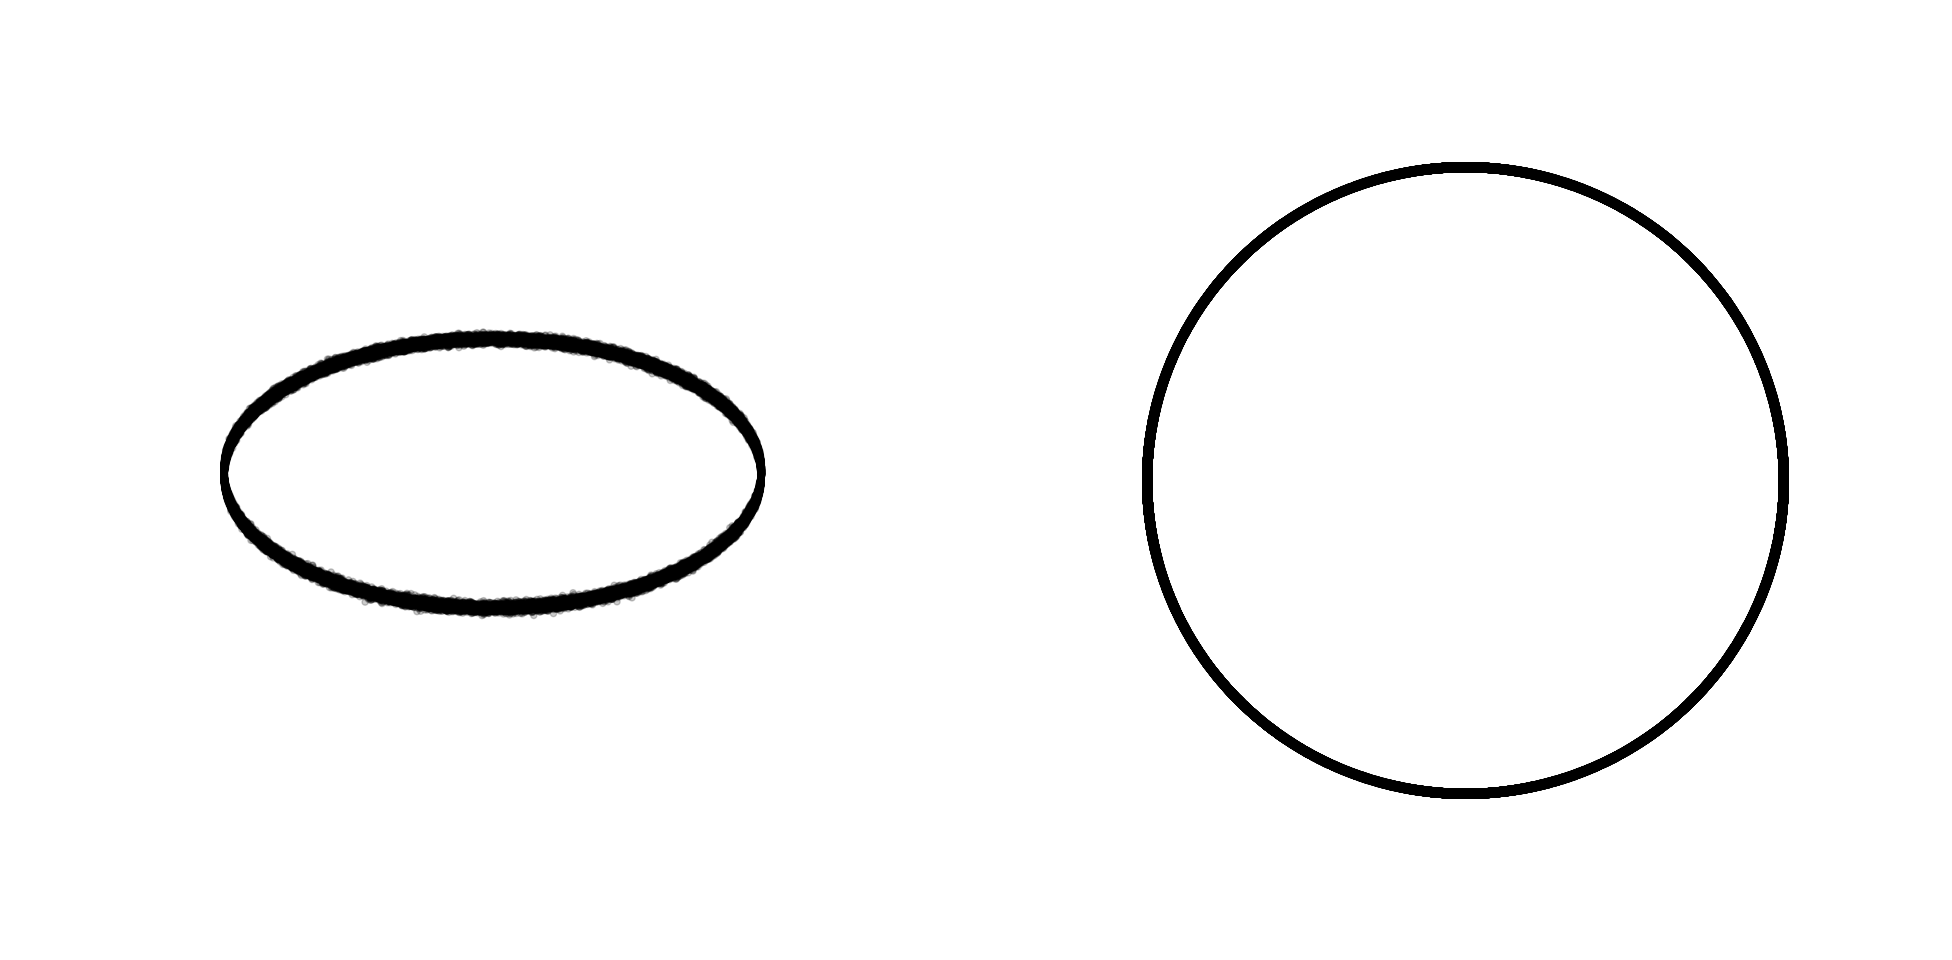

In [6]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], alpha=.2, color='black')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()

ax = fig.add_subplot(122)
ax.scatter(data[:,0], data[:,1], alpha=.2, color='black')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_axis_off()
fig.tight_layout()

### Loading Pre-Trained VAE

In [7]:
@hk.transform
def vae_model(x):


    vae = VAEBM(
    encoder=Encoder(latent_dim=latent_dim),
    decoder=Decoder(),
    sample_method = 'Euclidean',
    )

    return vae(x)

@hk.transform
def vae_G(z):


    vae = VAEBM(
    encoder=Encoder(latent_dim=latent_dim),
    decoder=Decoder(),
    sample_method = 'Euclidean',
    )

    return vae.G(z)

@hk.transform
def score_model(x):

    score = ScoreNet(
    dim=latent_dim,
    layers=[50,100,200,200,100,50],
    )

    return score(x)

@hk.transform
def decoder_model(z):

    decoder = Decoder()

    return decoder(z)

In [8]:
if type(vae_model) == hk.Transformed:
    vae_apply_fn = lambda params, data, rng_key, state_val: vae_model.apply(params, rng_key, data)
elif type(vae_model) == hk.TransformedWithState:
    vae_apply_fn = lambda params, data, rng_key, state_val: vae_model.apply(params, state_val, rng_key, data)[0]

In [9]:
if type(vae_model) == hk.Transformed:
    Gvae_apply_fn = lambda params, data, rng_key, state_val: vae_G.apply(params, rng_key, data)
elif type(vae_model) == hk.TransformedWithState:
    Gvae_apply_fn = lambda params, data, rng_key, state_val: vae_G.apply(params, state_val, rng_key, data)[0]

In [10]:
vae_state = load_model(vae_save_path_pretrained)

In [11]:
z, mu_xz, sigma_xz, mu_zx, t_zx, mu_z, t_z = vae_apply_fn(vae_state.params, data, vae_state.rng_key, vae_state.state_val)

In [19]:
print(mu_xz)

[[-1.0380531e+04  3.8156342e+02 -6.6470323e+00]
 [-8.1084351e+03  2.8172696e+02  4.5563567e-01]
 [-9.2176387e+03  3.5779474e+02  3.8747208e+01]
 ...
 [-7.9736499e+03  2.9164584e+02  1.4883711e+01]
 [-4.6743350e+03  1.6387245e+02 -2.5657680e+00]
 [-5.4491450e+03  2.6645377e+02 -9.6146479e+00]]


In [23]:
mu_zx

Array([[[0.3198048 , 0.03518151],
        [0.320056  , 0.03486225],
        [0.32031077, 0.0345449 ],
        ...,
        [0.33796   , 0.00726393],
        [0.33802152, 0.00700914],
        [0.3380837 , 0.00675504]],

       [[0.32003132, 0.03571442],
        [0.3202882 , 0.0353959 ],
        [0.32054862, 0.03507926],
        ...,
        [0.33869302, 0.00763466],
        [0.33875608, 0.00737678],
        [0.33881947, 0.00711964]],

       [[0.32025924, 0.03624969],
        [0.3205216 , 0.03593185],
        [0.32078725, 0.03561578],
        ...,
        [0.33942187, 0.00800739],
        [0.3394868 , 0.0077466 ],
        [0.33955178, 0.0074865 ]],

       ...,

       [[0.34729955, 0.07910569],
        [0.34767887, 0.07866611],
        [0.3480585 , 0.0782259 ],
        ...,
        [0.3840877 , 0.0343327 ],
        [0.3844474 , 0.03387036],
        [0.38480604, 0.03340845]],

       [[0.34764135, 0.0793274 ],
        [0.3480209 , 0.07888591],
        [0.3484007 , 0.07844359],
        .

### Plotting Pre-Trained VAE

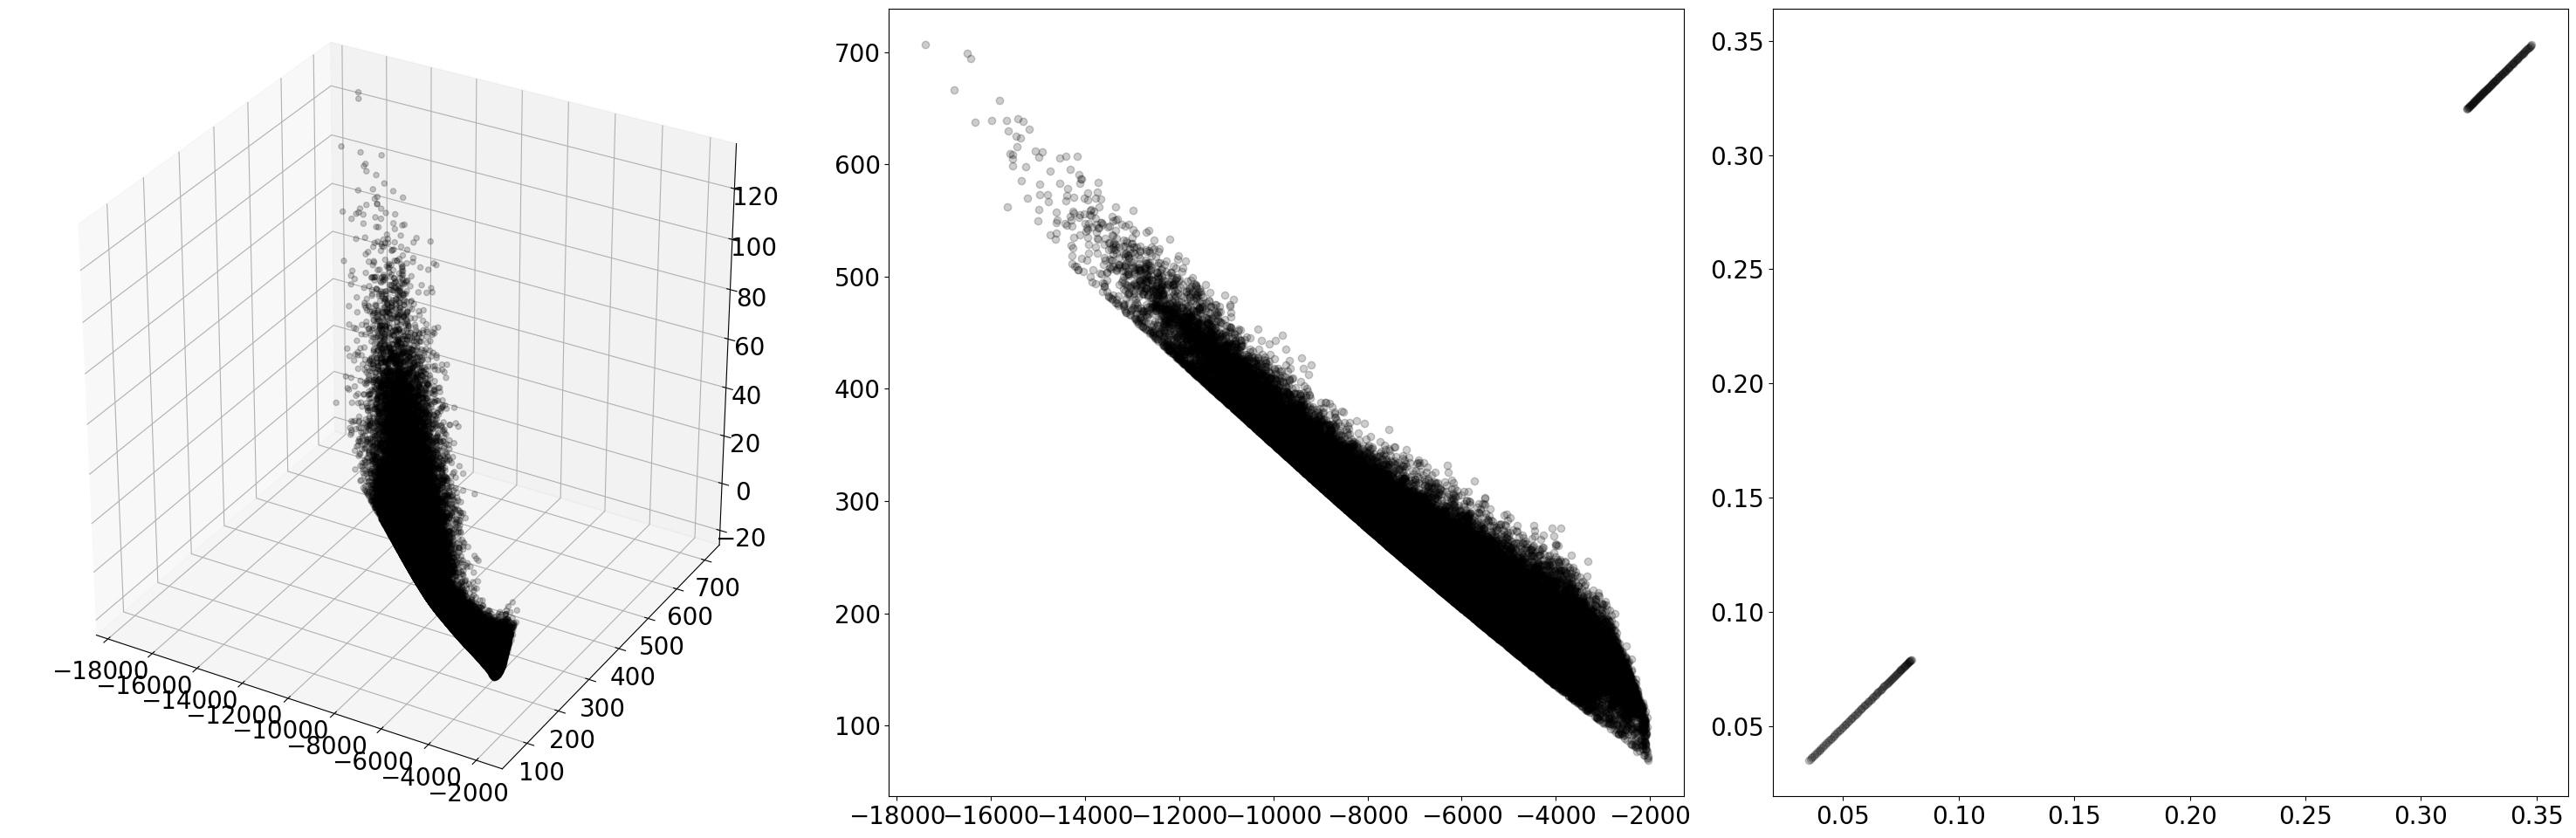

In [21]:
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(mu_xz[:,0], mu_xz[:,1], mu_xz[:,2], alpha=.2, color='black')
ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
#ax.set_axis_off()

ax = fig.add_subplot(132)
ax.scatter(mu_xz[:,0], mu_xz[:,1], alpha=.2, color='black')
#ax.set_xlim([-1.5,1.5])
#ax.set_ylim([-1.5,1.5])
#ax.set_axis_off()

ax = fig.add_subplot(133)
ax.scatter(mu_zx[:,0], mu_zx[:,1], alpha=.2, color='black')
#ax.set_axis_off()

fig.tight_layout()

### Plotting Pre-Trained Metric

In [13]:
x1 = jnp.linspace(-1.5, 1.5, 100)
x2 = jnp.linspace(-1.5, 1.5, 100)
X1, X2 = jnp.meshgrid(x1, x2)

In [14]:
X = jnp.transpose(jnp.stack((X1,X2, jnp.zeros_like(X1))), (1,2,0))

In [15]:
mu_zx = vmap(lambda x1: vmap(lambda x2: vae_apply_fn(vae_state.params, x2, vae_state.rng_key, vae_state.state_val).mu_zx)(x1))(X).squeeze()

In [16]:
g = vmap(lambda x1: vmap(lambda x2: Gvae_apply_fn(vae_state.params, x2, vae_state.rng_key, vae_state.state_val))(x1))(mu_zx).squeeze()

In [17]:
det_g = g = vmap(lambda x1: vmap(lambda x2: jnp.linalg.det(x2))(x1))(g).squeeze()

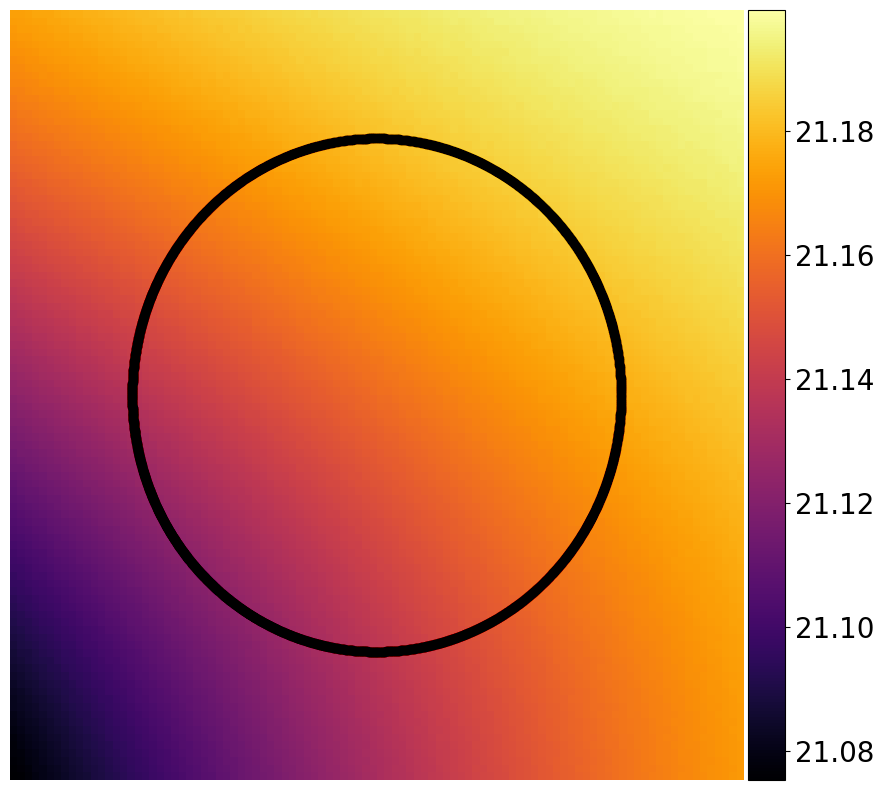

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(data[:,0],data[:,1], color='black', alpha=0.01)
ax.imshow(jnp.log(det_g), cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[-1.5,1.5,-1.5,1.5])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(jnp.log(det_g))
ax.autoscale(False)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
fig.colorbar(m, cax=cax, orientation='vertical', format=cbformat)#, cax=cax)